## From Bob Kowalewski's Mathematica notebook

Set up generation of data for two experiments to measure beam intensity.  Detectors are both fully efficient.  The acceptance due to absorption in the vacuum window at the end of the beamline is a common systematic.  Background is determined by a dedicated beam-off run, and it is assumed that the major contribution to background counts comes from real ambient radiation, so is correlated between the two detectors (since the background run was done simultaneously for the two).  The assumed variation in ambient background between the beam-off and beam-on runs is 5%.

Simulate a set of 10000 trials where the true beam intensity is 10.0 Hz, where the beam-on runs are 1000s long, where the acceptance correction for the vacuum window is 0.800+-0.016, where the duration of the beam-off run is 10000s, where the background rate during the beam-off run is 2.5Hz, and where the rms variation in background rate between beam-off and beam-on runs is 5%.  All quantities can be modeled as having normally-distributed uncertainties.

For each trial, take the number of counts generated, along with the estimated background rate, beam-on time and acceptance correction, and determine the beam intensity measured in each of the two detectors along with estimates of the uncertainties from statistical and systematic sources.  You should have, for each trial, two estimates of the beam intensity (one for each detector) and the associated uncertainties.  Using only this information, combine these into a single estimate of the beam intensity for each trial.  Based on the full set of trials, record the observed bias in the beam intensity determination and in the estimate of its uncertainty.  If you treat the measurements properly the bias should be consistent with zero.

In [1]:
from __future__ import division
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from time import time
from scipy.optimize import fsolve

# begin counting figures
ifig=0
for i in range(0,10000):
    plt.close(i)

def select_fig(ifig,close_fig=True):
    if close_fig:
        plt.close(ifig)
    plt.figure(ifig)
    
fsize=14
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'

init_printing()

In [2]:
# Clear[corbkg,bkrateR,BR];
BR = symbols('BR')

Input values for toy studies.  The assignment uses values obtained from one particular trial, given below

In [5]:
beamrateR = 10.0; # in Hertz, to be determined based on measurements 
nTsig1 = 1000.0; nTsig2 = 1000.0; # time with beam on (s) 
effaR = 0.80; deffaR = 0.016; # acceptance and uncertainty 
nTbkg = 10000.0; # background sample time duration 
corbkg = 0.05*10**(0); # fractional uncertainty associated with stability of background 
bkrateR = 2.5*10**(0); # nominal background rates in Hertz 

# Important !!!
nTrials = 100; # with 1000 it takes about 4 minutes to execute the loop, and 40 minutes with 10000

Set up arrays to keep track of generated counts and results

In [6]:
am1 = np.linspace(0,0,nTrials);
am2 = np.linspace(0,0,nTrials);
abkgm1 = np.linspace(0,0,nTrials);
abkgm2 = np.linspace(0,0,nTrials);
brAvg = np.linspace(0,0,nTrials);
ebrAvgp = np.linspace(0,0,nTrials);
ebrAvgm = np.linspace(0,0,nTrials);

Generate toy data, calculate the two BRs and average them for each trial

In [7]:
t=time()
for n in range(nTrials):
    thisbkg = (1 + np.random.normal()*corbkg); # variation in bkg rate relative to beam-off 
    bkrate = bkrateR *thisbkg; # background rate for generating beam-on counts  
    
    effa = effaR + deffaR*np.random.normal(); # acceptance for actual apparatus 
    
    m1 = np.random.poisson(nTsig1*effa*beamrateR); # counts recorded from beam 
    m1 += np.random.poisson(nTsig1*bkrate); # background in trial 
    m2 = np.random.poisson(nTsig2*effa*beamrateR);
    m2 += np.random.poisson(nTsig2*bkrate);
    am1[n] = m1; am2[n] = m2; # store generated counts 
    
    bkg1m = np.random.poisson(bkrateR*nTbkg)*nTsig1/nTbkg; # bkg counts, scaled to beam-on 
    bkg2m = np.random.poisson(bkrateR*nTbkg)*nTsig2/nTbkg;
    abkgm1[n] = bkg1m; abkgm2[n] = bkg2m; # store generated counts 
    
    vbkg11m = bkg1m*nTsig1/nTbkg + bkg1m**2*corbkg**2; # error on bkg estimate, including systematic 
    vbkg22m = bkg2m*nTsig2/nTbkg + bkg2m**2*corbkg**2;
    vbkg12m = bkg1m*bkg2m*corbkg**2; # correlated backround term 

    br1 = (m1-bkg1m)/nTsig1/effaR; # measured beam rate for detector 1 
    br2 = (m2-bkg2m)/nTsig2/effaR;
    BRin = (br1+br2)/2; # naive average; used to guide FindRoot below 

    f1 = BR/br1; f2 = BR/br2;  # this factor scales multiplicative uncertainties 
    
    Vstat = Matrix([[m1/nTsig1**2/effaR**2,0],[0,m2/nTsig2**2/effaR**2]]); # note use of nominal acceptance effaR 
    Vbkg  = Matrix([[vbkg11m/nTsig1**2/effaR**2,vbkg12m/nTsig1/nTsig2/effaR**2], 
             [vbkg12m/nTsig1/nTsig2/effaR**2,vbkg22m/nTsig2**2/effaR**2]]);
    VeffA = Matrix([[br1**2*f1**2*deffaR**2/effaR**2,br1*br2*f1*f2*deffaR**2/effaR**2], 
             [br1*br2*f1*f2*deffaR**2/effaR**2,br2**2*f2**2*deffaR**2/effaR**2]]);
    Vtot = Vstat+Vbkg+VeffA; # total covariance; depends on parameter BR 
    
    chi2 = (Matrix([br1-BR,br2-BR]).transpose()*Vtot.inv()*Matrix([br1-BR,br2-BR]))[0];
    dchi2 = chi2.diff(BR)
    def dfunc(x):
        return dchi2.subs(BR,x)
    aSol = fsolve(dfunc,BRin)
    BRave = aSol
    def func(x):
        return chi2.subs(BR,x)-(chi2.subs(BR,BRave)+1)
    brAvg[n] = BRave;
    aSol1 = fsolve(func,BRin+.15) # upper uncertainty
    errBRave1 = aSol1 - BRave;
    ebrAvgp[n] = errBRave1;
    aSol2 = fsolve(func,BRin-.15) # lower uncertainty
    errBRave2 = aSol2 - BRave;
    ebrAvgm[n] = errBRave2;
print time()-t

24.4063689709


In [8]:
print brAvg.mean()
print sqrt(brAvg.var())
print sqrt(brAvg.var()/nTrials)
print (brAvg.mean()-beamrateR)/sqrt(brAvg.var()/nTrials)
print ebrAvgp.mean()
print ebrAvgm.mean()
print sqrt((ebrAvgp.mean()**2+ebrAvgm.mean()**2)/2)
print (ebrAvgp.mean()**2+ebrAvgm.mean()**2-2*brAvg.var())/2
print sqrt((2*brAvg.var()**2/(nTrials-1)))
print (ebrAvgp.mean()**2+ebrAvgm.mean()**2-2*brAvg.var())/2/sqrt((2*brAvg.var()**2/(nTrials-1)))

10.0086082422
0.265571286021554
0.0265571286021554
0.324140545958923
0.274077211725
-0.266067121095
0.270101861262101
0.00242690749811
0.0100244287600633
0.242099331163674


The values below are the ones written into the assignment.  My algorithm's results using this input are shown.

In [9]:
m1 = 10213; m2 = 10067; bkg1m = 25068*nTsig1/nTbkg; bkg2m = 24805*nTsig1/nTbkg;
br1 = (m1-bkg1m)/nTsig1/effaR; # measured beam rate for detector 1 
br2 = (m2-bkg2m)/nTsig2/effaR;
BRin = (br1+br2)/2; # naive average; used to guide FindRoot below 
f1 = BR/br1; f2 = BR/br2;  # this factor scales multiplicative uncertainties     
Vstat = Matrix([[m1/nTsig1**2/effaR**2,0],[0,m2/nTsig2**2/effaR**2]]); # note use of nominal acceptance effaR 
vbkg11m = bkg1m*nTsig1/nTbkg + bkg1m**2*corbkg**2; # error on bkg estimate, including systematic 
vbkg22m = bkg2m*nTsig2/nTbkg + bkg2m**2*corbkg**2;
vbkg12m = bkg1m*bkg2m*corbkg**2; # correlated backround term 
t=time()
Vbkg  = Matrix([[vbkg11m/nTsig1**2/effaR**2,vbkg12m/nTsig1/nTsig2/effaR**2], 
            [vbkg12m/nTsig1/nTsig2/effaR**2,vbkg22m/nTsig2**2/effaR**2]]);
VeffA = Matrix([[br1**2*f1**2*deffaR**2/effaR**2,br1*br2*f1*f2*deffaR**2/effaR**2], 
            [br1*br2*f1*f2*deffaR**2/effaR**2,br2**2*f2**2*deffaR**2/effaR**2]]);
Vtot = Vstat+Vbkg+VeffA; # total covariance; depends on parameter BR  
print time()-t

t=time()
chi2 = (Matrix([br1-BR,br2-BR]).transpose()*Vtot.inv()*Matrix([br1-BR,br2-BR]))[0];
print time()-t

t=time()
dchi2 = chi2.diff(BR)
print time()-t
t=time()
# aSol = nsolve(dchi2,BR,BRin)
def dfunc(x):
        return dchi2.subs(BR,x)
aSol = fsolve(dfunc,BRin)
print time()-t
t=time()
BRave = aSol
def func(x):
        return chi2.subs(BR,x)-(chi2.subs(BR,BRave)+1)
aSol1 = fsolve(func,BRin+0.15) # upper uncertainty
print time()-t
t=time()
errBRave1 = aSol1 - BRave;
aSol2 = fsolve(func,BRin-0.15) # lower uncertainty
errBRave2 = aSol2 - BRave;
print time()-t

0.00677895545959
0.102093935013
0.0219538211823
0.045567035675
0.0381970405579
0.0424160957336


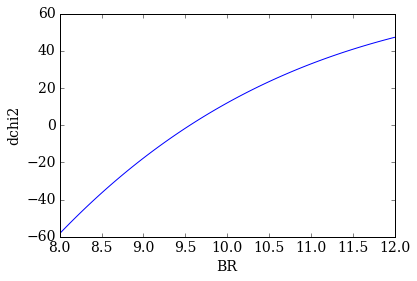

In [11]:
fn=lambdify(BR,dchi2,"numpy")
xn=np.linspace(8,12,100)
yn=fn(xn)
ifig=ifig+1
plt.close(ifig),select_fig(ifig)
plt.plot(xn,yn)
plt.xlabel("BR")
plt.ylabel("dchi2")
plt.show()

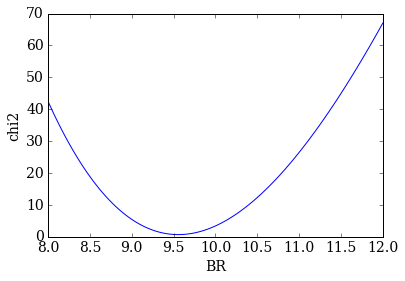

In [12]:
fn=lambdify(BR,chi2,"numpy")
xn=np.linspace(8,12,100)
yn=fn(xn)
ifig=ifig+1
plt.close(ifig),select_fig(ifig)
plt.plot(xn,yn)
plt.xlabel("BR")
plt.ylabel("chi2")
plt.show()

In [13]:
print BRave
print errBRave1
print errBRave2
print chi2.subs(BR,BRave)
print (0.05/0.80*2.5)**2
print BRave**2*(.016/.80)**2
A = Vtot.subs(BR,BRave)
print A
print br1
print br2
A = Vtot.subs(BR,BRave)
print sqrt(A[0,0]-A[0,1])

[ 9.55622187]
[ 0.26645185]
[-0.25880381]
0.689498237015023
0.0244140625
[ 0.03652855]
Matrix([[0.0774251062179213, 0.0608180716866713], [0.0608180716866713, 0.0766805046944838]])
9.63275
9.483125
0.128868283651370


Split out the components of the covariance

In [14]:
print Vtot.subs(BR,brAvg.mean())
print Vbkg
print Vstat
print VeffA.subs(BR,brAvg.mean())

Matrix([[0.0809654512030469, 0.0643584166717969], [0.0643584166717969, 0.0802208496796094]])
Matrix([[0.0249387431250000, 0.0242895210937500], [0.0242895210937500, 0.0244222666015625]])
Matrix([[0.0159578125000000, 0], [0, 0.0157296875000000]])
Matrix([[0.0400688955780469, 0.0400688955780469], [0.0400688955780469, 0.0400688955780469]])


In [15]:
m12 = (m1 + m2)/2; b12 = (bkg1m + bkg2m)/2;
br12 = (m12-b12)/nTsig1/effaR
Var12 = (m12/2 + b12/2 + b12**2*corbkg**2)/(nTsig1*effaR)**2 + br12**2*deffaR**2/effaR**2;
print br12
print sqrt(Var12)

9.5579375
0.265898295098574
